In [21]:
#!pip install pandas
#!pip install imageio
#!pip install opencv-python
#!pip install SimpleITK
#!pip install pyradiomics
#!pip install ruamel.yaml
#created by d.sneha@wustl.edu
#Dated Aug 25, 2024 Sunday

In [1]:
import imageio as iio
import os
import cv2
import glob
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import sklearn

In [2]:
import pandas as pd
import math
from PIL import Image
import io
from IPython.display import display
from PIL import Image as PILImage
from IPython.display import display
import SimpleITK as sitk
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Importing packages:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats
from scipy.stats import skew

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing 
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

file = "/fsx1/encode/Image_records/Android_processed/"
print(file)
parameter_path = "./Pyradiomics_Params.yaml"
path_save = "/home/jupyter-sneha/Android_processed/radiomics/"


#3: palm left dorsal 
for (dirpath, dirnames, filenames) in os.walk(file):
    img_files = os.path.join(dirpath, "*_3_android.jpg")
    for img_file in glob.glob(img_files):
        print(img_file)
        img = cv2.imread(img_file)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_gray = rgb2gray(img_rgb)
        print(type(img_gray)) ##type of image##
        print(img_gray.shape) ##image shape##
        print(np.max(np.unique(img_gray))) ##check max intensity values##
        print(np.min(np.unique(img_gray))) ##check min intensity values##
        if (np.isnan(img_gray)==True).any(): ##no nan values##
            print("found") 
        ###cropping image
        # Step 1: Find non-zero (or non-background) pixels
        non_zero_rows = np.any(img_gray != 0, axis=1)
        non_zero_cols = np.any(img_gray != 0, axis=0)
        
        # Step 2: Determine the bounding box of non-background area
        row_min, row_max = np.where(non_zero_rows)[0][[0, -1]]
        col_min, col_max = np.where(non_zero_cols)[0][[0, -1]]
        
        # Step 3: Crop the image to this bounding box
        cropped_img = img_gray[row_min:row_max+1, col_min:col_max+1]

        ###normalization
        img_mean = cropped_img.mean()
        img_std = cropped_img.std()
        standard_img = (cropped_img - img_mean) / img_std
        print(f"Processed Image: (mean={cropped_img.mean():.2f}, std={cropped_img.std():.2f})")
        print(f"Standardized Image: (mean={standard_img.mean():.2f}, std={standard_img.std():.2f})")

        threshold_value = 0.1  # You can adjust this value based on your needs

        # Step 2: Create the mask
        mask_arr = cropped_img > threshold_value  # Pixels greater than the threshold become True
        
        # Step 3: Convert the boolean mask to an integer mask (optional)
        mask_arr = mask_arr.astype(np.uint8)  # Convert boolean to 0 and 1 (optional)
        
        study_path = img_file.split('/')
        print(study_path[5])
        # Display the mask
        #plt.imshow(mask, cmap='gray')
        #plt.show()
        
        fig, axs = plt.subplots(1, 3, dpi=300, constrained_layout=True, sharey=True)
        axs[0].imshow(cropped_img, 'gray')
        axs[1].imshow(standard_img, 'gray')
        axs[2].imshow(mask_arr, 'gray')
        axs[0].set_title("Processed Image")
        axs[1].set_title("Standardized Image")
        axs[2].set_title("Mask of Image")
        plt.show()

        # Convert the image and mask NumPy arrays to SimpleITK images
        image = sitk.GetImageFromArray(cropped_img)
        mask = sitk.GetImageFromArray(mask_arr)
            
                # Create the PyRadiomics feature extractor
        extractor = featureextractor.RadiomicsFeatureExtractor(parameter_path)
                
                # Enable or disable the features you want to calculate
        extractor.disableAllFeatures()
        extractor.enableFeatureClassByName('firstorder')
        extractor.settings['binCount'] = 20
        extractor.settings['distances'] = [1]
                # Calculate the features using the image and mask
        result = extractor.execute(image, mask)
        feature = []
        value = []
                # Access the calculated features
        for feature_name in result.keys():
            print(f"{feature_name}: {result[feature_name]}")
            feature.append(feature_name)
            value.append(result[feature_name])
        df = pd.DataFrame(feature, columns=['Feature'])
        df['Value']=value
        df.to_csv(path_save+study_path[5] + '_' + 'img_features.csv')

        break

In [4]:
#reading the compiled radiomic features csv file documented per women basis
path= '/home/jupyter-sneha/'
file = 'final_concatenated_dataset.csv'
df = pd.read_csv(path+file)

In [5]:
df = df[df["Location"] == "PALM_LEFT DORSAL"]


In [6]:
df

,Person_ID,birth_datetime,gender,race,ethnicity,visit_occurrence_id,visit_start_datetime,visit_end_datetime,age,measurement_id,...,Oxygen content in Arterial blood,Invasive Diastolic blood pressure,Invasive Systolic blood pressure,Lactate [Moles/volume] in Blood,Ratio of arterial oxygen tension to inspired oxygen fraction,Carbon dioxide [Partial pressure] adjusted to patient's actual temperature in Arterial blood,Inhaled oxygen concentration,Calcium.ionized [Mass/volume] in Arterial blood,Methemoglobin/Hemoglobin.total in Arterial blood,Invasive Mean blood pressure
0,17,2023-01-27 09:00:00+00:00,MALE,Black or African American,Not Hispanic or Latino,17,2073-04-19 02:31:00+00:00,2073-05-26 03:20:00+00:00,50,877035,...,78.0,NaN,NaN,NaN,217.0,39.0,36.0,NaN,0.0,NaN
5,17,2023-01-27 09:00:00+00:00,MALE,Black or African American,Not Hispanic or Latino,17,2073-04-19 02:31:00+00:00,2073-05-26 03:20:00+00:00,50,882877,...,173.0,61.0,96.0,15.0,433.0,31.0,40.0,1.20,0.3,74.0
6,17,2023-01-27 09:00:00+00:00,MALE,Black or African American,Not Hispanic or Latino,17,2073-04-19 02:31:00+00:00,2073-05-26 03:20:00+00:00,50,883174,...,141.0,62.0,95.0,13.4,470.0,37.0,30.0,1.11,0.5,74.0
11,17,2023-01-27 09:00:00+00:00,MALE,Black or African American,Not Hispanic or Latino,17,2073-04-19 02:31:00+00:00,2073-05-26 03:20:00+00:00,50,886450,...,145.0,75.0,98.0,NaN,363.0,42.0,40.0,NaN,1.0,84.0
14,17,2023-01-27 09:00:00+00:00,MALE,Black or African American,Not Hispanic or Latino,17,2073-04-19 02:31:00+00:00,2073-05-26 03:20:00+00:00,50,876252,...,13.7,71.0,124.0,NaN,410.0,34.0,30.0,NaN,0.6,89.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5762,45,2006-03-04 01:00:00+00:00,MALE,White,Not Hispanic or Latino,45,2073-05-09 18:47:00+00:00,2073-06-12 18:45:00+00:00,67,875901,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5766,45,2006-03-04 01:00:00+00:00,MALE,White,Not Hispanic or Latino,45,2073-05-09 18:47:00+00:00,2073-06-12 18:45:00+00:00,67,891206,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5767,45,2006-03-04 01:00:00+00:00,MALE,White,Not Hispanic or Latino,45,2073-05-09 18:47:00+00:00,2073-06-12 18:45:00+00:00,67,895376,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5770,45,2006-03-04 01:00:00+00:00,MALE,White,Not Hispanic or Latino,45,2073-05-09 18:47:00+00:00,2073-06-12 18:45:00+00:00,67,884283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df = df.drop(columns=["Image", "Unnamed: 0"])

In [8]:
df.columns

Index(['Person_ID', 'birth_datetime', 'gender', 'race', 'ethnicity',
       'visit_occurrence_id', 'visit_start_datetime', 'visit_end_datetime',
       'age', 'measurement_id', 'measurement_concept_id',
       'measurement_datetime', 'value_as_number', 'concept_id', 'concept_name',
       'Location', 'measurment_type', 'measurment_type_dtls', 'image_datetime',
       'Location_Number', 'original_firstorder_10Percentile',
       'original_firstorder_90Percentile', 'original_firstorder_Energy',
       'original_firstorder_Entropy', 'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean',
       'original_firstorder_Median', 'original_firstorder_Minimum',
       'original_firstorder_Range',
       'original_firstorder_RobustMeanAbsoluteDeviation',
       'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness',
       'original_firstorder_Tota

In [9]:
#df.columns
#df_filtered = df.iloc[:,20:38]
#df_filtered.columns

In [10]:
columns_to_add = ["Blood pressure device Cuff pressure.mean", "Location", "Body temperature", "sao2", "spo2", "gender", "race", "ethnicity", "person_id"]
df_filtered = df[columns_to_add]

In [11]:
df_filtered = df_filtered.drop_duplicates(subset="person_id")
df_filtered = df_filtered.dropna(subset=["person_id"])

In [12]:
df_filtered.columns

Index(['Blood pressure device Cuff pressure.mean', 'Location',
       'Body temperature', 'sao2', 'spo2', 'gender', 'race', 'ethnicity',
       'person_id'],
      dtype='object')

In [13]:
df_filtered['Diff_Spo2_Sao2'] = df['spo2'] - df['sao2']
df_filtered['Hypotension'] = df_filtered['Blood pressure device Cuff pressure.mean'].apply(lambda x: 1 if x > 65 else 0)

In [14]:
df_filtered.reset_index(inplace=True, drop = True)
df_filtered

,Blood pressure device Cuff pressure.mean,Location,Body temperature,sao2,spo2,gender,race,ethnicity,person_id,Diff_Spo2_Sao2,Hypotension
0,142.0,PALM_LEFT DORSAL,37.0,95.9,92.0,MALE,Black or African American,Not Hispanic or Latino,108.0,-3.9,1
1,92.0,PALM_LEFT DORSAL,37.0,97.9,99.0,MALE,Black or African American,Not Hispanic or Latino,73.0,1.1,1
2,NaN,PALM_LEFT DORSAL,35.9,98.0,100.0,MALE,Black or African American,Not Hispanic or Latino,46.0,2.0,0
3,74.0,PALM_LEFT DORSAL,37.0,97.7,100.0,MALE,Black or African American,Not Hispanic or Latino,78.0,2.3,1
4,NaN,PALM_LEFT DORSAL,36.8,97.2,100.0,MALE,Black or African American,Not Hispanic or Latino,23.0,2.8,0
...,...,...,...,...,...,...,...,...,...,...,...
84,NaN,PALM_LEFT DORSAL,36.5,98.2,95.0,MALE,Other,Not Hispanic or Latino,101.0,-3.2,0
85,NaN,PALM_LEFT DORSAL,36.8,97.0,100.0,MALE,Other,Not Hispanic or Latino,86.0,3.0,0
86,NaN,PALM_LEFT DORSAL,37.0,94.9,99.0,MALE,Other,Not Hispanic or Latino,62.0,4.1,0
87,NaN,PALM_LEFT DORSAL,35.9,95.9,96.0,MALE,Other,Not Hispanic or Latino,32.0,0.1,0


In [15]:
file_radiomics = 'all_images_features.csv'
df_radiomics = pd.read_csv(path+file_radiomics)
df_radiomics.columns

Index(['Image', 'original_firstorder_10Percentile',
       'original_firstorder_90Percentile', 'original_firstorder_Energy',
       'original_firstorder_Entropy', 'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean',
       'original_firstorder_Median', 'original_firstorder_Minimum',
       'original_firstorder_Range',
       'original_firstorder_RobustMeanAbsoluteDeviation',
       'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness',
       'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity',
       'original_firstorder_Variance'],
      dtype='object')

In [16]:
df_radiomics['person_id'] = ''

# Iterate over the 'Image' column, extract the desired part, and store it in 'Image_id'
for index, i in df_radiomics['Image'].items():
    image_id = i.split("/")[5].split("_")[0]
    df_radiomics.at[index, 'person_id'] = image_id

In [17]:
np.unique(df_radiomics["person_id"])

array(['0', '1', '10', '100', '101', '102', '103', '104', '105', '106',
       '107', '109', '11', '110', '112', '113', '114', '115', '116',
       '117', '118', '119', '12', '120', '121', '122', '123', '124',
       '125', '126', '127', '128', '14', '15', '16', '17', '18', '19',
       '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '3',
       '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4',
       '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5',
       '50', '51', '52', '53', '54', '56', '57', '58', '59', '6', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70',
       '71', '72', '74', '75', '76', '77', '78', '79', '8', '80', '81',
       '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91',
       '92', '93', '94', '95', '96', '97', '98', '99'], dtype=object)

In [18]:
# Convert 'person_id' and 'image_id' columns to integers in both DataFrames
df_radiomics['person_id'] = df_radiomics['person_id'].astype(int)

df_filtered['person_id'] = df_filtered['person_id'].astype(int)


# Merge the two DataFrames on 'person_id' and 'Image_id'
df_merged = pd.merge(df_radiomics, df_filtered, on=['person_id'])

In [19]:
df_merged

,Image,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,...,Blood pressure device Cuff pressure.mean,Location,Body temperature,sao2,spo2,gender,race,ethnicity,Diff_Spo2_Sao2,Hypotension
0,/fsx1/encode/Image_records/iPhone_processed/76...,0.674003,0.855117,1.085708e+06,3.175024,0.090844,3.626995,1.000000,0.056775,0.755084,...,107.0,PALM_LEFT DORSAL,37.0,97.7,100.0,MALE,White,Not Hispanic or Latino,2.3,1
1,/fsx1/encode/Image_records/iPhone_processed/12...,0.724418,0.846694,1.154449e+06,3.160869,0.061414,3.796095,1.000000,0.038490,0.782627,...,NaN,PALM_LEFT DORSAL,36.5,97.3,100.0,MALE,White,Not Hispanic or Latino,2.7,0
2,/fsx1/encode/Image_records/iPhone_processed/77...,0.687732,0.814108,1.133975e+06,3.244519,0.063043,4.717804,1.000000,0.039929,0.751033,...,77.0,PALM_LEFT DORSAL,37.0,97.0,97.0,MALE,White,Not Hispanic or Latino,0.0,1
3,/fsx1/encode/Image_records/iPhone_processed/12...,0.709244,0.850005,1.117116e+06,3.390475,0.072493,3.453291,1.000000,0.043859,0.775464,...,NaN,PALM_LEFT DORSAL,38.3,96.8,95.0,MALE,Black or African American,Not Hispanic or Latino,-1.8,0
4,/fsx1/encode/Image_records/iPhone_processed/80...,0.757256,0.863764,1.175910e+06,3.349273,0.053868,3.383301,0.969722,0.033309,0.813560,...,100.0,PALM_LEFT DORSAL,36.6,84.3,86.0,MALE,Other,Not Hispanic or Latino,1.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,/fsx1/encode/Image_records/iPhone_processed/91...,0.727468,0.860363,1.203870e+06,3.381292,0.071162,3.583421,1.000000,0.042370,0.790789,...,106.0,PALM_LEFT DORSAL,35.2,98.4,100.0,MALE,Other,Not Hispanic or Latino,1.6,1
81,/fsx1/encode/Image_records/iPhone_processed/7_...,0.785280,0.864055,1.236778e+06,2.680024,0.042312,3.296056,0.987625,0.025059,0.826063,...,NaN,PALM_LEFT DORSAL,36.4,95.9,98.0,MALE,White,Not Hispanic or Latino,2.1,0
82,/fsx1/encode/Image_records/iPhone_processed/93...,0.732305,0.883960,1.340798e+06,3.546256,0.077866,2.630093,1.000000,0.045671,0.814680,...,76.0,PALM_LEFT DORSAL,34.0,97.3,100.0,MALE,Black or African American,Not Hispanic or Latino,2.7,1
83,/fsx1/encode/Image_records/iPhone_processed/92...,0.547136,0.791449,1.099621e+06,3.590521,0.133706,2.704047,0.998586,0.076196,0.663427,...,98.0,PALM_LEFT DORSAL,38.6,96.7,97.0,MALE,Black or African American,Not Hispanic or Latino,0.3,1


In [21]:
df_rad = df_merged.iloc[:,1:19]
df_rad

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance
0,0.674003,0.855117,1.085708e+06,3.175024,0.090844,3.626995,1.000000,0.056775,0.755084,0.743505,0.368409,0.631591,0.038420,0.758562,0.721915,1.085708e+06,0.133262,0.005264
1,0.724418,0.846694,1.154449e+06,3.160869,0.061414,3.796095,1.000000,0.038490,0.782627,0.779900,0.540959,0.459041,0.025751,0.784218,0.255816,1.154449e+06,0.136269,0.002493
2,0.687732,0.814108,1.133975e+06,3.244519,0.063043,4.717804,1.000000,0.039929,0.751033,0.747962,0.551555,0.448445,0.026315,0.752886,0.572540,1.133975e+06,0.129824,0.002786
3,0.709244,0.850005,1.117116e+06,3.390475,0.072493,3.453291,1.000000,0.043859,0.775464,0.770650,0.568283,0.431717,0.030159,0.777468,0.522129,1.117116e+06,0.113395,0.003112
4,0.757256,0.863764,1.175910e+06,3.349273,0.053868,3.383301,0.969722,0.033309,0.813560,0.816705,0.629474,0.340248,0.022781,0.814666,-0.370315,1.175910e+06,0.117151,0.001800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0.727468,0.860363,1.203870e+06,3.381292,0.071162,3.583421,1.000000,0.042370,0.790789,0.786419,0.578084,0.421916,0.028978,0.792637,0.507301,1.203870e+06,0.114581,0.002927
81,0.785280,0.864055,1.236778e+06,2.680024,0.042312,3.296056,0.987625,0.025059,0.826063,0.827912,0.572972,0.414653,0.017332,0.826673,-0.165162,1.236778e+06,0.185060,0.001009
82,0.732305,0.883960,1.340798e+06,3.546256,0.077866,2.630093,1.000000,0.045671,0.814680,0.820069,0.608147,0.391853,0.032655,0.816623,-0.199751,1.340798e+06,0.097928,0.003170
83,0.547136,0.791449,1.099621e+06,3.590521,0.133706,2.704047,0.998586,0.076196,0.663427,0.654685,0.364645,0.633941,0.054664,0.670031,0.327117,1.099621e+06,0.094388,0.008806


In [22]:
for i in df_rad.columns:
    a = np.asarray(df_rad[i], dtype=np.float64)
    a = stats.zscore(a, ddof=1) 
    df_rad[i] = a
print(df_rad.columns)

Index(['original_firstorder_10Percentile', 'original_firstorder_90Percentile',
       'original_firstorder_Energy', 'original_firstorder_Entropy',
       'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean',
       'original_firstorder_Median', 'original_firstorder_Minimum',
       'original_firstorder_Range',
       'original_firstorder_RobustMeanAbsoluteDeviation',
       'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness',
       'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity',
       'original_firstorder_Variance'],
      dtype='object')


In [ ]:
#excluding features with extremely low variation (interquartile range<1)
iqr_values = df_rad.quantile(0.75) - df_rad.quantile(0.25)
threshold = 1  # Set the threshold for the IQR below which columns will be excluded
low_var_columns = iqr_values[iqr_values < threshold].index
dropped_columns = df_rad[low_var_columns]
#print(dropped_columns.info())
df_rad = df_rad.drop(low_var_columns, axis=1)

In [23]:
# excluding features with extreme skewness
skewness = df_rad.apply(skew)
threshold = 1  # the threshold was adjusted according to the requirements
extreme_skew_columns = skewness[abs(skewness) > threshold].index
dropped_columns = df_rad[extreme_skew_columns]
print(dropped_columns.info())
df_rad = df_rad.drop(extreme_skew_columns, axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 7 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   original_firstorder_InterquartileRange           85 non-null     float64
 1   original_firstorder_Kurtosis                     85 non-null     float64
 2   original_firstorder_Maximum                      85 non-null     float64
 3   original_firstorder_MeanAbsoluteDeviation        85 non-null     float64
 4   original_firstorder_RobustMeanAbsoluteDeviation  85 non-null     float64
 5   original_firstorder_Uniformity                   85 non-null     float64
 6   original_firstorder_Variance                     85 non-null     float64
dtypes: float64(7)
memory usage: 4.8 KB
None


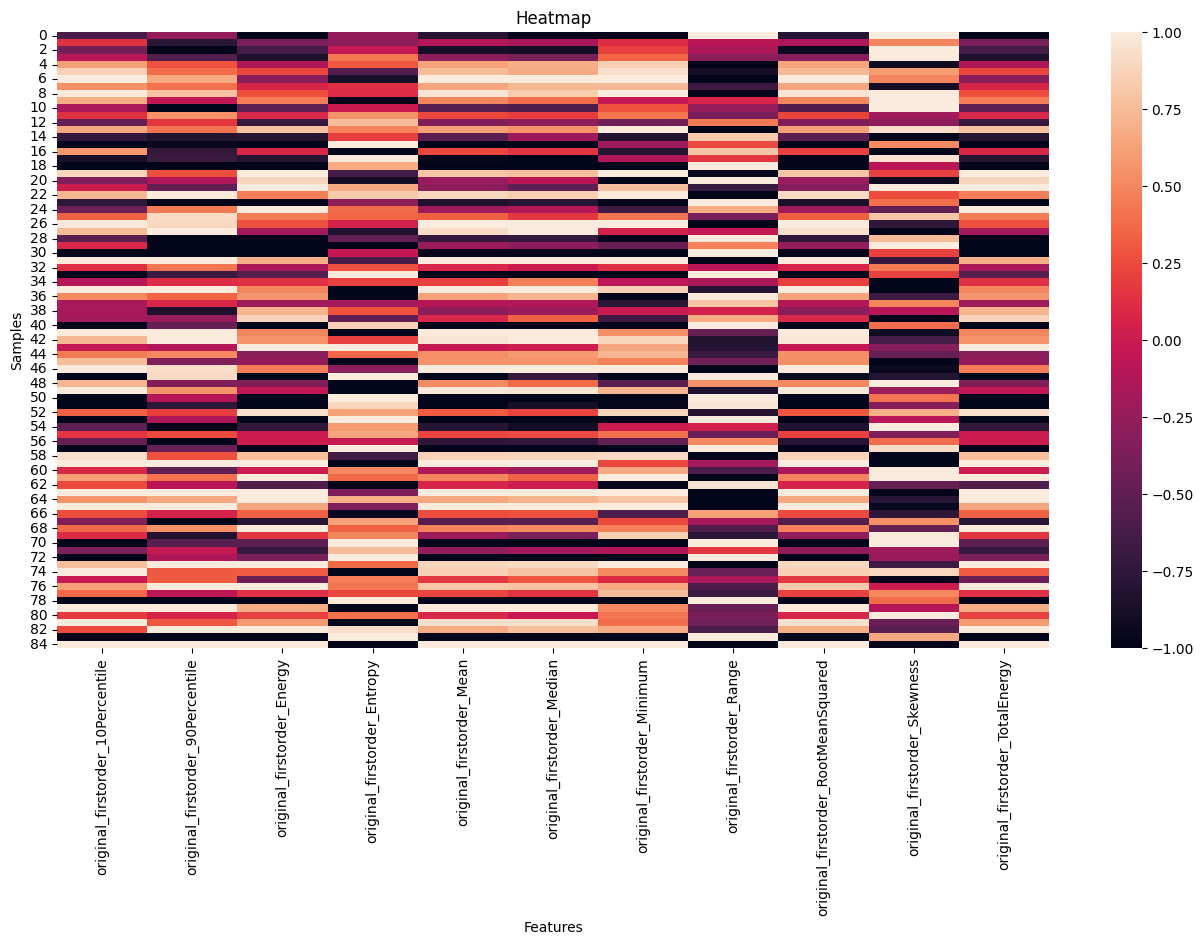

In [25]:
#PCA
# Set the figure size
plt.figure(1, figsize = (16 ,8))
sns.heatmap(df_rad, vmax=1, vmin=-1)

# Create the heatmap using the sorted data
#sns.heatmap(sorted_data)

# Add labels and adjust plot settings as needed
plt.xlabel('Features')
plt.ylabel('Samples')
plt.title('Heatmap')

# Display the plot
plt.show()

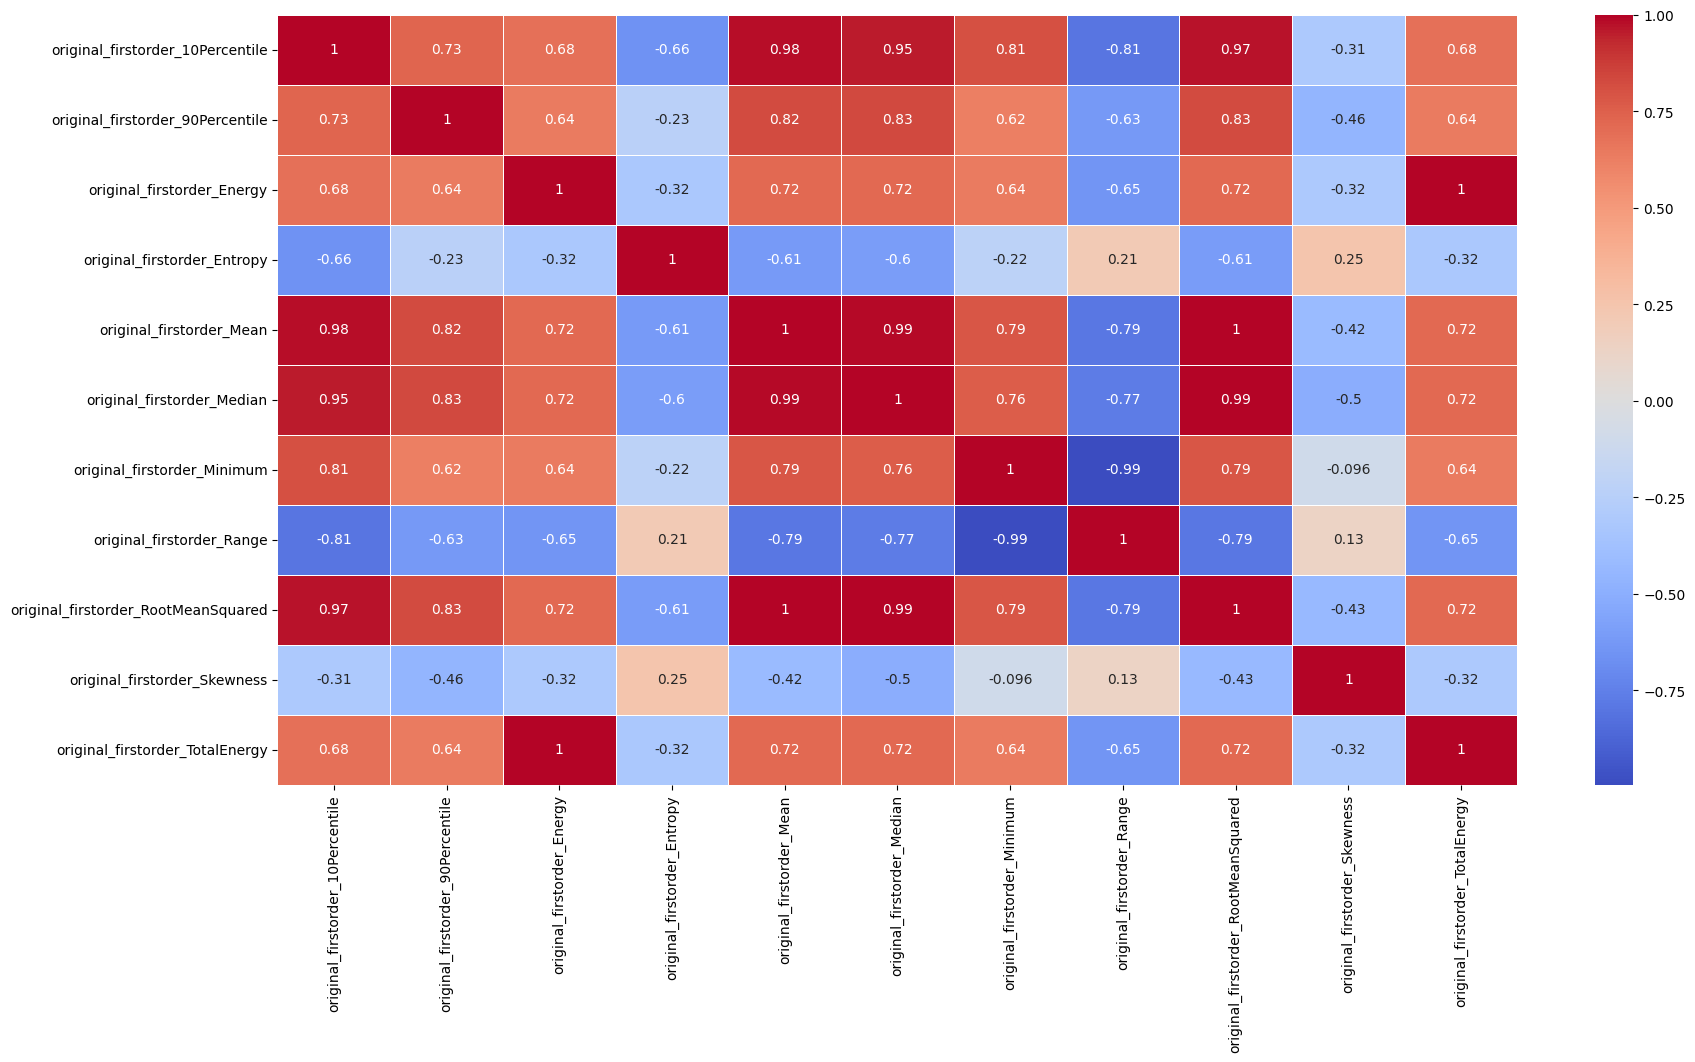

In [26]:
header = df_rad.columns
#print(header)
k = df_rad.corr(method='spearman')
#print(k)
plt.figure(figsize=(20, 10))
sns.heatmap(k, annot=True, cmap='coolwarm', linewidths=0.5)
#plt.title(f'Spearman Correlation between VOLUMETRIC_PERCENT_DENSITY and Other Columns')
plt.show()


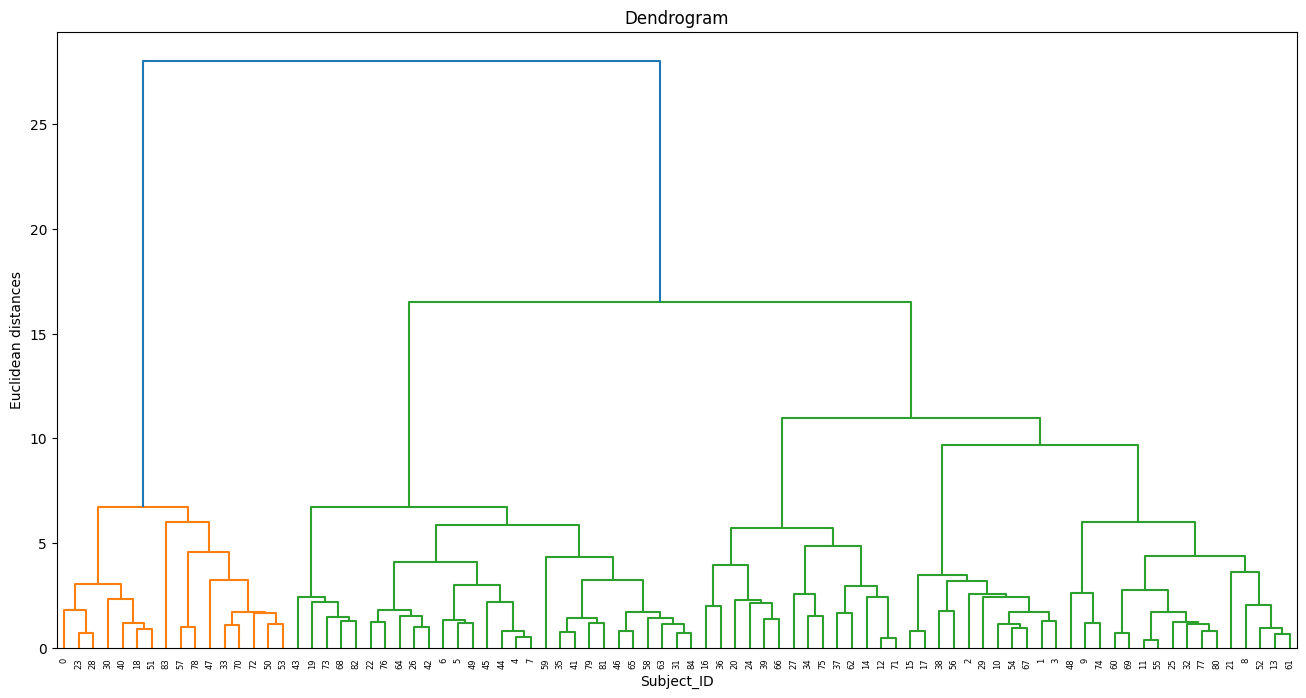

In [28]:
#Constructing dendogram:
plt.figure(1, figsize = (16 ,8))
linkage_matrix = sch.linkage(df_rad, method  = "ward", metric="euclidean")
# Compute the cophenetic correlation coefficient
coph_corr, coph_dists = cophenet(linkage_matrix, pdist(df_rad))

dendrogram = sch.dendrogram(linkage_matrix)
plt.title('Dendrogram')
plt.xlabel('Subject_ID')
plt.ylabel('Euclidean distances')
plt.show()

In [29]:
#PCA
from sklearn.decomposition import PCA
pca = PCA(n_components= len(df_rad.columns))
pca.fit_transform(df_rad)
pca.explained_variance_ratio_.cumsum()
#3 pcs preserving a 89% of total variance

array([0.68314636, 0.79732414, 0.88945003, 0.95710245, 0.99561195,
       0.99909597, 0.99975161, 0.99998786, 0.99999798, 1.        ,
       1.        ])

In [30]:
np.abs(pca.components_)

array([[3.49317045e-01, 2.75739094e-01, 2.97601682e-01, 1.91690027e-01,
        3.58120238e-01, 3.55638016e-01, 3.06393108e-01, 3.07867106e-01,
        3.58158226e-01, 1.28071285e-01, 2.97601682e-01],
       [2.92458447e-02, 1.22092712e-01, 1.36282759e-01, 5.04925156e-01,
        9.13007600e-02, 1.37359958e-01, 4.11964618e-01, 3.99504267e-01,
        9.76723348e-02, 5.71034744e-01, 1.36282759e-01],
       [2.69283193e-01, 3.47269515e-01, 2.69855087e-01, 5.71888823e-01,
        1.11007002e-01, 5.49649169e-02, 6.15961473e-02, 3.56635810e-02,
        9.55427264e-02, 5.51952896e-01, 2.69855087e-01],
       [5.07009042e-02, 2.16567958e-01, 5.63447405e-01, 2.86385983e-01,
        1.04728288e-01, 1.24223769e-01, 2.58920113e-01, 2.63921957e-01,
        1.10762460e-01, 2.41252036e-01, 5.63447405e-01],
       [4.80554035e-02, 7.64226014e-01, 5.03863466e-02, 5.20225899e-02,
        7.04896276e-02, 1.76339084e-02, 2.30020081e-01, 2.62917860e-01,
        9.07787462e-02, 5.19913260e-01, 5.03863466e-

In [32]:
pca = PCA(n_components=3)
pcs = pca.fit_transform(df_rad)

In [33]:
pcs.shape

(85, 3)

In [42]:
df_vitals = df_merged.iloc[:,20:30]
df_vitals.columns

Index(['Blood pressure device Cuff pressure.mean', 'Location',
       'Body temperature', 'sao2', 'spo2', 'gender', 'race', 'ethnicity',
       'Diff_Spo2_Sao2', 'Hypotension'],
      dtype='object')

In [45]:
#Transforming principal components in a dataframe
col_name = []
for i in range(1,4):
    pcs_col_name = 'pc'+'_'+str(i)
    #print(pcs_col_name)
    col_name.append(pcs_col_name)   
df_principal_components = pd.DataFrame(data=pcs,columns=col_name)
#print(df_principal_components)
df_combined = pd.concat([df_principal_components, df_vitals], axis=1)
df_combined

,pc_1,pc_2,pc_3,Blood pressure device Cuff pressure.mean,Location,Body temperature,sao2,spo2,gender,race,ethnicity,Diff_Spo2_Sao2,Hypotension
0,-2.858981,-0.278857,-1.239196,107.0,PALM_LEFT DORSAL,37.0,97.7,100.0,MALE,White,Not Hispanic or Latino,2.3,1
1,-0.492520,0.245169,-0.939734,NaN,PALM_LEFT DORSAL,36.5,97.3,100.0,MALE,White,Not Hispanic or Latino,2.7,0
2,-2.296737,1.304810,-1.678696,77.0,PALM_LEFT DORSAL,37.0,97.0,97.0,MALE,White,Not Hispanic or Latino,0.0,1
3,-1.061305,1.061967,-0.933973,NaN,PALM_LEFT DORSAL,38.3,96.8,95.0,MALE,Black or African American,Not Hispanic or Latino,-1.8,0
4,1.543269,0.077929,0.283917,100.0,PALM_LEFT DORSAL,36.6,84.3,86.0,MALE,Other,Not Hispanic or Latino,1.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0.283095,1.165560,-0.329291,106.0,PALM_LEFT DORSAL,35.2,98.4,100.0,MALE,Other,Not Hispanic or Latino,1.6,1
81,2.463297,-1.074876,-0.942355,NaN,PALM_LEFT DORSAL,36.4,95.9,98.0,MALE,White,Not Hispanic or Latino,2.1,0
82,2.635184,0.758180,2.039528,76.0,PALM_LEFT DORSAL,34.0,97.3,100.0,MALE,Black or African American,Not Hispanic or Latino,2.7,1
83,-6.988472,1.148621,-0.187430,98.0,PALM_LEFT DORSAL,38.6,96.7,97.0,MALE,Black or African American,Not Hispanic or Latino,0.3,1


In [55]:
import shap

ImportError: Numba needs NumPy 2.0 or less. Got NumPy 2.1.

In [ ]:
#the selector:
fs_all_pca = PCA(n_components=3).fit(df_rad)
X_all_pca = fs_all_pca.transform(df_rad)
y = df_combined["sao2"]
#the model:
# train the linear model
model = sklearn.linear_model.LinearRegression().fit(X_all_pca, y)
explainer = shap.Explainer(model.predict, X_all_pca)
shap_values = explainer(X_all_pca)


In [56]:
df_combined.columns

Index(['pc_1', 'pc_2', 'pc_3', 'Blood pressure device Cuff pressure.mean',
       'Location', 'Body temperature', 'sao2', 'spo2', 'gender', 'race',
       'ethnicity', 'Diff_Spo2_Sao2', 'Hypotension'],
      dtype='object')

In [61]:
#!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 109.0 MB/s eta 0:00:00


In [62]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [73]:
X = df_combined[['Hypotension', 'Body temperature', 'Diff_Spo2_Sao2']]
Y = df_combined[['pc_1']]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   pc_1   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.7836
Date:                Sun, 25 Aug 2024   Prob (F-statistic):              0.507
Time:                        15:15:13   Log-Likelihood:                -204.61
No. Observations:                  85   AIC:                             417.2
Df Residuals:                      81   BIC:                             427.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               14.9882     12.240  

In [82]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Gaussian
from statsmodels.genmod.cov_struct import Exchangeable
family = Gaussian()
cov_struct = Exchangeable()
formula_sao2 = ('sao2 ~ Hypotension + pc_1 + pc_2 + pc_3' )
model_sao2 = GEE.from_formula(formula_sao2, data=df_combined, groups=df_combined.index, family=family, cov_struct=cov_struct)
result_sao2 = model_sao2.fit()
print("GEE Results for sao2")
print(result_sao2.summary())
formula_spo2 = ('Diff_Spo2_Sao2 ~ Hypotension + pc_1 + pc_2 + pc_3')
model_diff = GEE.from_formula(formula_spo2, data=df_combined, groups=df_combined.index, family=family, cov_struct=cov_struct)
result_diff = model_diff.fit()
print("\nGEE Results for spo2")
print(result_diff.summary())

GEE Results for sao2
                               GEE Regression Results                              
Dep. Variable:                        sao2   No. Observations:                   85
Model:                                 GEE   No. clusters:                       85
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   1
Family:                           Gaussian   Mean cluster size:                 1.0
Dependence structure:         Exchangeable   Num. iterations:                     1
Date:                     Sun, 25 Aug 2024   Scale:                           8.015
Covariance type:                    robust   Time:                         15:28:57
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      95.8194      0.315    304.533      0.000      95

In [85]:
#Sub-group Analysis
df_combined.columns


Index(['pc_1', 'pc_2', 'pc_3', 'Blood pressure device Cuff pressure.mean',
       'Location', 'Body temperature', 'sao2', 'spo2', 'gender', 'race',
       'ethnicity', 'Diff_Spo2_Sao2', 'Hypotension'],
      dtype='object')

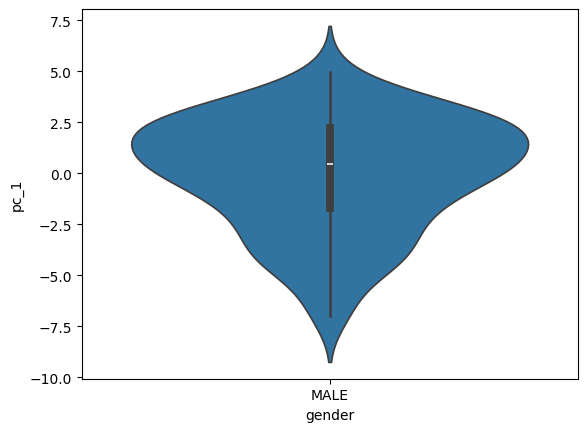

In [91]:
sns.violinplot(data=df_combined, x= df_combined["gender"], y= df_combined["pc_1"])
plt.show()

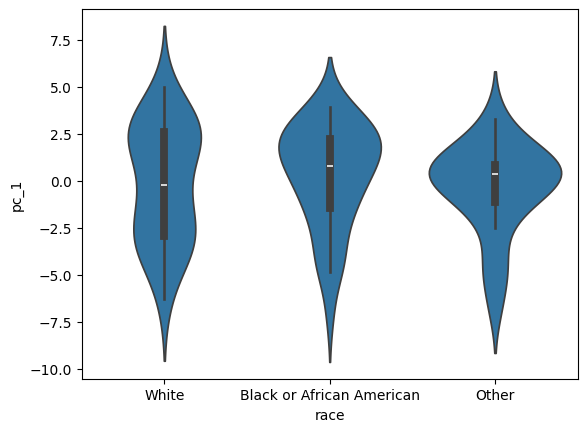

In [87]:
sns.violinplot(data=df_combined, x= df_combined["race"], y= df_combined["pc_1"])
plt.show()

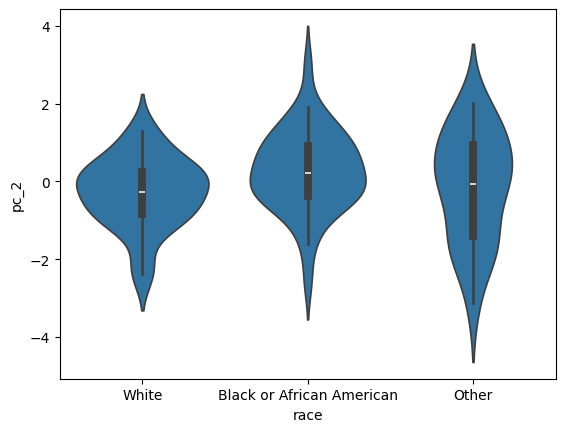

In [88]:
sns.violinplot(data=df_combined, x= df_combined["race"], y= df_combined["pc_2"])
plt.show()

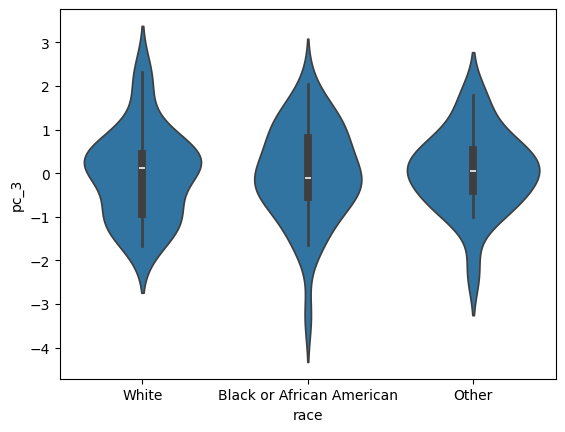

In [93]:
sns.violinplot(data=df_combined, x= df_combined["race"], y= df_combined["pc_3"])
plt.show()

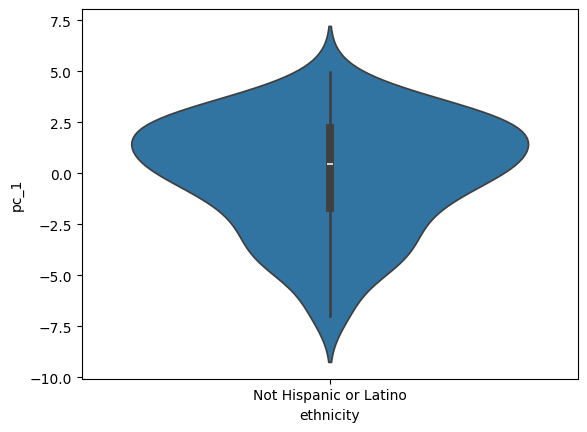

In [92]:
sns.violinplot(data=df_combined, x= df_combined["ethnicity"], y= df_combined["pc_1"])
plt.show()